# Implement RRT and its variant on UR5

## Load UR5 and the world around it
- For development reasons, I re-used the environment provided in the lab_0 to be in a nearly "unit-test" simple 2D configuration space.
- This can be triggered using the `reduced=True` flag

In [54]:
viz = None
feasible_state_2d = None # only if reduce=True

In [55]:
import hppfcl
import numpy as np
import pinocchio as pin
from typing import List, Tuple
import itertools

from utils.meshcat_viewer_wrapper import colors
from pinocchio.utils import rotate
# SIMPLE CASE (reduced ~ 2D)
def add_obstacles_reduced(robot):
    def XYZRPYtoSE3(xyzrpy):
        rotate = pin.utils.rotate
        R = rotate('x',xyzrpy[3]) @ rotate('y',xyzrpy[4]) @ rotate('z',xyzrpy[5])
        p = np.array(xyzrpy[:3])
        return pin.SE3(R,p)
    # Capsule obstacles will be placed at these XYZ-RPY parameters
    oMobs = [ [ 0.40,  0.,  0.30, np.pi/2,0,0],
              [-0.08, -0.,  0.69, np.pi/2,0,0],
              [ 0.23, -0.,  0.04, np.pi/2, 0 ,0 ],
              [-0.32,  0., -0.08, np.pi/2, 0, 0]]
    rad,length = .1,0.4                                  # radius and length of capsules
    for i,xyzrpy in enumerate(oMobs):
        obs = pin.GeometryObject.CreateCapsule(rad,length)  # Pinocchio obstacle object
        obs.meshColor = np.array([ 1.0, 0.2, 0.2, 1.0 ])    # Don't forget me, otherwise I am transparent ...
        obs.name = "obs%d"%i                                # Set object name
        obs.parentJoint = 0                                 # Set object parent = 0 = universe
        obs.placement = XYZRPYtoSE3(xyzrpy)  # Set object placement wrt parent
        robot.collision_model.addGeometryObject(obs)  # Add object to collision model
        robot.visual_model   .addGeometryObject(obs)  # Add object to visual model

    ### Collision pairs
    nobs = len(oMobs)
    nbodies = robot.collision_model.ngeoms-nobs
    robotBodies = range(nbodies)
    envBodies = range(nbodies,nbodies+nobs) 
    robot.collision_model.removeAllCollisionPairs()
    for a,b in itertools.product(robotBodies,envBodies):
        robot.collision_model.addCollisionPair(pin.CollisionPair(a,b))
# HARD CASE (6 degrees of freedom)
def add_obstacles_hard(robot):
    def addCylinderToUniverse(name, radius, length, placement, color=colors.red):
        geom = pin.GeometryObject(
            name,
            0,
            hppfcl.Cylinder(radius, length),
            placement
        )
        new_id = robot.collision_model.addGeometryObject(geom)
        geom.meshColor = np.array(color)
        robot.visual_model.addGeometryObject(geom)
        
        for link_id in range(robot.model.nq):
            robot.collision_model.addCollisionPair(
                pin.CollisionPair(link_id, new_id)
            )
        return geom
    [robot.collision_model.removeGeometryObject(e.name) for e in 
     robot.collision_model.geometryObjects if e.name.startswith('world/')]

    # Add a red box in the viewer
    radius = 0.1
    length = 1.

    cylID = "world/cyl1"
    placement = pin.SE3(pin.SE3(rotate('z',np.pi/2), np.array([-0.5,0.4,0.5])))
    addCylinderToUniverse(cylID,radius,length,placement,color=[.7,.7,0.98,1])


    cylID = "world/cyl2"
    placement = pin.SE3(pin.SE3(rotate('z',np.pi/2), np.array([-0.5,-0.4,0.5])))
    addCylinderToUniverse(cylID,radius,length,placement,color=[.7,.7,0.98,1])

    cylID = "world/cyl3"
    placement = pin.SE3(pin.SE3(rotate('z',np.pi/2), np.array([-0.5,0.7,0.5])))
    addCylinderToUniverse(cylID,radius,length,placement,color=[.7,.7,0.98,1])


    cylID = "world/cyl4"
    placement = pin.SE3(pin.SE3(rotate('z',np.pi/2), np.array([-0.5,-0.7,0.5])))
    addCylinderToUniverse(cylID,radius,length,placement,color=[.7,.7,0.98,1])




def add_special_locations(robot, viz, q_list:List[Tuple[np.ndarray, str, str]], robot_effector=22) -> None:
    """Add some markers at the source and target locations"""
    colors = {
        "red": [1., 0., 0., 1.],
        "green": [0., 1., 0., 1.]
    }
    for q, name, color in q_list:
        M = robot.framePlacement(q, robot_effector)
        name = f"world/{name}"
        ball_radius = 0.05
        viz.addSphere(name, ball_radius, colors.get(color, [1., 1., 1., 1.]))
        viz.applyConfiguration(name, M)


In [56]:
from pinocchio.robot_wrapper import RobotWrapper
from utils.meshcat_viewer_wrapper import MeshcatVisualizer, colors
import example_robot_data as robex

def initialize_problem(reduced=False) -> Tuple[RobotWrapper, MeshcatVisualizer]:
    """Initialize a world with a ur5 robot

    Args:
        reduced (bool, optional): Simplified problem. Defaults to False.

    Returns:
        robot, viz
    """
    robot = robex.load('ur5')
    if reduced:
        unlocks = [1,2]
        robot.model,[robot.visual_model,robot.collision_model]\
            = pin.buildReducedModel(robot.model,[robot.visual_model,robot.collision_model],
                                    [ i+1 for i in range(robot.nq) if i not in unlocks ],robot.q0)
        robot.data = robot.model.createData()
        robot.collision_data = robot.collision_model.createData()
        robot.visual_data = robot.visual_model.createData()
        robot.q0 = robot.q0[unlocks].copy()
    if reduced:
        add_obstacles_reduced(robot)
    else:
        add_obstacles_hard(robot)
    return robot


### Initialize the world

In [57]:
reduced = True

robot = initialize_problem(reduced=reduced)
if reduced:
    # q_i= np.deg2rad([-90., 40.]) #EASY
    q_i= np.deg2rad([-170., 0.]) #NOT EASY
    q_g= np.deg2rad([-79., 64.])
else:
    q_i = np.array([1., -1.5, 2.1, -.5, -.5, 0])
    q_g = np.array([3., -1., 1, -.5, -.5, 0])
if viz is None:
    viz = MeshcatVisualizer(robot)

add_special_locations(
    robot,
    viz,
    [
        (q_i, "initial", "red"),
        (q_g, "goal", "green")
    ]
)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


## Implement everything needed for RRT

We abstract the robot the environment and its behaviour in a class call `System`

It must be able to:
- generate random configuration which are not colliding if needed (sampling)
- implement a distance on the configuration space (distance)
- generate path between two configuration (steering)
- check if a path is free between two configuration and return the latest free config (directional free steering)
and some function to display the configuration.

Recall that in the case of the UR5 the configuration space is $S_1^{6}$, where $S_1$ is the unit cirle, we can parametrize by $\theta\in[-\pi,\pi]$ such that $-\pi$ and $\pi$ are identified.

In the next cell, you must implement the system behaviour for the UR5.

In [58]:
import numpy as np
from typing import Union, Tuple

from utils.collision_wrapper import CollisionWrapper
from pinocchio.robot_wrapper import RobotWrapper
import time
import pinocchio as pin


class System():
    def __init__(self, robot: RobotWrapper, dof=6):
        self.robot = robot
        robot.gmodel = robot.collision_model
        self.display_edge_count = 0
        self.colwrap = CollisionWrapper(robot)  # For collision checking
        self.nq = self.robot.nq
        self.display_count = 0
        self.dof = dof # degrees of freedom
    
    @staticmethod
    def distance(q1: np.ndarray, q2: np.ndarray) -> Union[float, np.array]:
        """
        Distance between q1 and q2 in the config space
        supports batch of config.
        """
        if len(q2.shape) > len(q1.shape):
            q1 = q1[None, ...]
        
        e = np.mod(np.abs(q1 - q2), 2 * np.pi)
        e[e > np.pi] = 2 * np.pi - e[e > np.pi]
        return np.linalg.norm(e, axis=-1)

    def random_config(self, free=True) -> np.ndarray:
        """
        Return a random configuration which is not in collision if free=True
        Does not set the robot in this configuration
        """
        q = 2 * np.pi * np.random.rand(self.dof) - np.pi  # [-pi, pi]^6
        if not free:
            return q
        while self.is_colliding(q):
            q = 2 * np.pi * np.random.rand(self.dof) - np.pi
        return q

    def is_colliding(self, q: np.array) -> bool:
        """
        Uses CollisionWrapper to decide if a configuration is in collision
        """
        # @TODO: are self collisions handled here
        self.colwrap.computeCollisions(q)
        collisions = self.colwrap.getCollisionList()
        return (len(collisions) > 0)

    def get_path(self, q1: np.array, q2: np.array, l_min=None, l_max=None, eps: float=0.2) -> np.ndarray:
        """Generate a straight continuous path (in the config space) between q1 and q2
        with precision eps (in radians) between q1 and q2 
        If l_min or l_max is mentioned, extrapolate or cut the path such
            - if l_min > d , extrapolate path_length=l_min
            - if l_max < d, cut path_length=l_max
        otherwise, if l_min<d(q1,q2)<l_max , path_length=d(q1,q2)
        
        ```

                         cut l_max <d         standard    extrapolate l_min>d
                              |                  |             |
                              v                  v             v
        [q1, q2] -> [q1, ... , ... ,... , ... ,  q2]    ........
                        <->
                        eps
        ```
        """
        q1 = np.mod(q1 + np.pi, 2 * np.pi) - np.pi
        q2 = np.mod(q2 + np.pi, 2 * np.pi) - np.pi

        diff = q2 - q1
        query = np.abs(diff) > np.pi
        q2[query] = q2[query] - np.sign(diff[query]) * 2 * np.pi

        d = self.distance(q1, q2)
        if d < eps:
            # precision is higher than the provided segment
            # return the original segment (q1 & q2 endpoints, nothing in-between)
            return np.stack([q1, q2], axis=0)
        
        if l_min is not None or l_max is not None:
            new_d = np.clip(d, l_min, l_max)
        else:
            new_d = d
            
        N = int(new_d / eps + 2)

        return np.linspace(q1, q1 + (q2 - q1) * new_d / d, N)
        
    def is_free_path(self, q1: np.ndarray, q2: np.ndarray, l_min=0.2, l_max=1., eps=0.2) -> Tuple[bool, np.ndarray]:
        """
        Create a path and check collision to return the last
        non-colliding configuration.
        Return X, q  -> q is the last state before collision, 
        in a max range of length l_max (steer a unitary vector in the diretion of q2)
        if no obstacle in the way, we shall have q= q1 + l_max*(q2-q1)/|q2-q1|
        where X is a boolean which state if the steering has worked.
        We require at least l_min must be cover without collision to validate the path.
        """
        q_path = self.get_path(q1, q2, l_min, l_max, eps)
        N = len(q_path)
        N_min = N - 1 if l_min is None else min(N - 1, int(l_min / eps))
        for i in range(N):
            if self.is_colliding(q_path[i]):
                break
        if i < N_min:
            return False, None
        if i == N - 1:
            return True, q_path[-1] # return the last point of the path
        return True, q_path[i - 1] # return the last point before collision
    
    # --------------------------------------------------------------------------------
    # Visualization functions
    # --------------------------------------------------------------------------------
    def add_visualizer(self, viz):
        self.viz = viz # Avoids using global variables

    def reset(self):
        """
        Reset the system visualization
        """
        for i in range(self.display_count):
            self.viz.delete(f"world/sph{i}")
            self.viz.delete(f"world/cil{i}")
        self.display_count = 0
    
    def display_edge(self, q1: np.ndarray, q2: np.ndarray, radius=0.01, color=[0., 1., 0., 1]):
        """Visualize an edge"""
        M1 = self.robot.framePlacement(q1, 22)  # Placement of the end effector tip.
        M2 = self.robot.framePlacement(q2, 22)  # Placement of the end effector tip.
        middle = .5 * (M1.translation + M2.translation)
        direction = M2.translation - M1.translation
        length = np.linalg.norm(direction)
        dire = direction / length
        orth = np.cross(dire, np.array([0, 0, 1]))
        orth2 = np.cross(dire, orth)
        Mcyl = pin.SE3(np.stack([orth2, dire, orth], axis=1), middle)
        name = f"world/sph{self.display_count}"
        self.viz.addSphere(name, radius, [1.,0.,0.,1])
        self.viz.applyConfiguration(name,M2)
        name = f"world/cil{self.display_count}"
        self.viz.addCylinder(name, length, radius / 4, color)
        self.viz.applyConfiguration(name, Mcyl)
        self.display_count +=1
        
    def display_motion(self, qs: np.ndarray, step=1e-1):
        # Given a point path display the smooth movement
        for i in range(len(qs) - 1):
            for q in self.get_path(qs[i], qs[i+1])[:-1]:
                self.viz.display(q)
                time.sleep(step)
        self.viz.display(qs[-1])


In [59]:
system = System(robot, dof=2 if reduced else 6)
system.add_visualizer(viz) # REQUIRED TO AVOID GLOBAL VARIABLES


In [60]:
# some sanity checks on distance computations
system.distance(np.array([q_i, q_i]), np.array([q_i, q_g]))

# system.distance(np.array([np.pi-0.1]), np.array([[-np.pi+0.1], [0.]]))
# system.distance(np.array([[-np.pi+0.1], [0.]]), np.array([[np.pi-0.1]]))

# system.distance(np.array([-np.pi+0.1, 0.]), np.array([[np.pi-0.1, 0.2], [np.pi-0.1, -0.1]]))
# system.distance(np.array([[np.pi-0.1, 0.2], [np.pi-0.1, -0.1]]), np.array([-np.pi+0.1, 0.]))

array([0.        , 1.94171311])

## Note on checking if a path is free
We have to be careful with the sampling throughout the whole development. Taking a high epsilon will significatically speed up the collision checks
but you may get infeasible path. A trick I proposed later in the BiRRT is to progressively increase the sampling rate, especially if we find the last "bridge" between the tree growing up from source and the tree growing up from the target. We start

In [61]:
for eps in np.linspace(1.5, 0.1, num=10):
    %timeit -r 2 -n 3 sucess, _ = system.is_free_path(q_i, q_g, l_min=None, l_max=None, eps=eps)
    print(f"Epsilon: {eps:.1f}, Feasible path {sucess=}") # WARNING ON ACCURACY

system.display_motion(system.get_path(q_i, q_g)) # Animate - this straight path will collide along the way



12.9 ms ± 473 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 1.5, Feasible path sucess=False
10.9 ms ± 666 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 1.3, Feasible path sucess=False
11.3 ms ± 850 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 1.2, Feasible path sucess=False
10.4 ms ± 151 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 1.0, Feasible path sucess=False
11 ms ± 409 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 0.9, Feasible path sucess=False
15.6 ms ± 1.5 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 0.7, Feasible path sucess=False
14.8 ms ± 1.11 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 0.6, Feasible path sucess=False
15 ms ± 1.21 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 0.4, Feasible path sucess=False
20.7 ms ± 1.37 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
Epsilon: 0.3, Feasible path sucess=False
40.1 ms ± 6

## RRT implementation

In its most simple form, RRT construct a tree from the start, eventually with a bias toward the goal. In the following class, we add some memoization to avoid recomputing distances. The kNN (k Nearest Neighbors) structure works on node indices.

Let us look at an implementation the core algorithm:

In [97]:
import numpy as np
from system import System
from typing import Callable
from utils.datastructures.storage import Storage
from utils.datastructures.pathtree import PathTree
from utils.datastructures.mtree import MTree
from tqdm import tqdm

class RRT():
    """
    Can be splited into RRT base because different rrt
    have factorisable logic
    """
    def __init__(
        self,
        system: System,
        node_max: int = 500000,
        iter_max: int = 1000000,
        N_bias: int=10,
        l_min: float =.2,
        l_max: float =.5,
        steer_delta: float=.1,
    ) -> None:
        '''Class implementing the RRT (Rapidly exploring Random Tree) algorithm.
        Creates a tree (a special kind of graph)
        starting from the source
        and progressively sampling free paths until reaching the target.

        Args:
            system (System): contains the Robotwrapper and a few helpers to perform computations in the configuration space.
            node_max (int, optional): maximum number of nodes in the tree. Defaults to 500000.
            iter_max (int, optional): maximum number of iterations. Defaults to 1000000.
            N_bias (int, optional): Every N_bias iterations, replace the random candidate by the goal itself. Defaults to 10.
            l_min (float, optional): minimal length granted of the new edges added to the graph. Defaults to .2.
            l_max (float, optional): maximal length granted of the new edges added to the graph. Defaults to .5.
            steer_delta (float, optional): path between the intermediate nodes when adding a new candidate branch to the tree.
            Also defines the resolutio of the collision check . Defaults to .1.
        '''
        self.system = system
        # params
        self.l_max = l_max
        self.l_min = l_min
        self.N_bias = N_bias
        self.node_max = node_max
        self.iter_max = iter_max
        self.steer_delta = steer_delta
        # intern
        self.NNtree = None
        self.storage = None
        self.pathtree = None
        # The distance function will be called on N, dim object
        self.real_distance = self.system.distance
        # Internal for computational_opti in calculating distance
        self._candidate = None
        self._goal = None
        self._cached_dist_to_candidate = {}
        self._cached_dist_to_goal = {}

    def distance(self, q1_idx: int, q2_idx: int) -> float:
        """Compute the real distance
        
        Args:
            q1_idx (int): start node index (in the tree)
            q2_idx (int): end node index (in the tree)

        Returns:
            float: distance
        """
        # Along the tree of the feasible path between q1 & q2
        # (not the naïve straight line euclian distance in the configuration space)

        if isinstance(q2_idx, int):
            if q1_idx == q2_idx:
                return 0. # requesting twice the same node -> 0
            if q1_idx == -1 or q2_idx == -1:
                if q2_idx == -1:
                    q1_idx, q2_idx = q2_idx, q1_idx
                if q2_idx not in self._cached_dist_to_candidate:
                    self._cached_dist_to_candidate[q2_idx] = self.real_distance(
                        self._candidate, self.storage[q2_idx]
                    )
                return self._cached_dist_to_candidate[q2_idx]
            if q1_idx == -2 or q2_idx == -2:
                if q2_idx == -2:
                    q1_idx, q2_idx = q2_idx, q1_idx
                if q2_idx not in self._cached_dist_to_goal:
                    self._cached_dist_to_goal[q2_idx] = self.real_distance(
                        self._goal, self.storage[q2_idx]
                    )
                return self._cached_dist_to_goal[q2_idx]
            return self.real_distance(self.storage[q1_idx], self.storage[q2_idx])
        if q1_idx == -1:
            q = self._candidate
        elif q1_idx == -2:
            q = self._goal
        else:
            q = self.storage[q1_idx]
        return self.real_distance(q, self.storage[q2_idx])

    def new_candidate(self) -> np.ndarray:
        """Sample a candidate in the free space. 
        Init self._candidate, reset _cached_dist_to_candidate
        """
        q = self.system.random_config(free=True)
        self._candidate = q
        self._cached_dist_to_candidate = {}
        return q

    def solve(self, qi: np.ndarray, validate: Callable, qg: np.ndarray=None) -> bool:
        """Run the algorithm

        Args:
            qi (np.ndarray): initial configuration
            validate (Callable): function which returns True if you reach your target
            qg (np.ndarray, optional): goal/target configuration. 
            Defaults to None (validate may be enough to contain the fact of reaching the target).
            Goal is required when using the N_bias

        Returns:
            bool: sucess
        """
        self.system.reset()
        self._goal = qg
        
        # Reset internal datastructures
        self.storage = Storage(self.node_max, self.system.nq)
        self.pathtree = PathTree(self.storage) # to store the tree of the path only
        self.NNtree = MTree(self.distance) # to store the exploration tree
        # Root of the tree = initial state qi
        qi_idx = self.storage.add_point(qi)
        self.NNtree.add_point(qi_idx)
        self.it_trace = []

        found = False
        iterator = range(self.iter_max)
        for i in tqdm(iterator):
            # Sample new candidate
            if i % self.N_bias == 0: 
                # Every N_bias times, let's force the candadidate to the goal!
                q_new = self._goal
                q_new_idx = -2
            else:
                # Standard random sampling
                q_new = self.new_candidate()
                q_new_idx = -1

            # Find closest neighboor to q_new in the NNtree
            q_near_idx, d = self.NNtree.nearest_neighbour(q_new_idx) # q_new_idx = -1 (or -2 in case of bias in favor of the target).
            
            # Steer from it toward the new checking for colision, with  a max length of lmax.
            # q_prox is a single feasible state (not the whole segment)
            success, q_prox = self.system.is_free_path(
                self.storage.data[q_near_idx],
                q_new,
                l_min=self.l_min,
                l_max=self.l_max,
                eps=self.steer_delta
            )

            if not success:
                self.it_trace.append(0)
                continue
            self.it_trace.append(1)
            
            # Add the q_prox point as new node in data structure
            q_prox_idx = self.storage.add_point(q_prox) # add the q_prox point to the storage, get new index
            self.NNtree.add_point(q_prox_idx) # add the node q_prox to the graph
            self.pathtree.update_link(q_prox_idx, q_near_idx)
            self.system.display_edge(self.storage[q_near_idx], self.storage[q_prox_idx])

            # Test if it reach the goal
            if validate(q_prox):
                q_g_idx = self.storage.add_point(q_prox)
                self.NNtree.add_point(q_g_idx)
                self.pathtree.update_link(q_g_idx, q_prox_idx)
                found = True
                break
        self.iter_done = i + 1
        self.found = found
        return found

    def get_path(self, q_g):
        assert self.found
        path = self.pathtree.get_path()
        return np.concatenate([path, q_g[None, :]])

In proper code, we would document the parameters of our functions.

- **Your turn:** Add docstrings to the code above, following the [Google style](https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html).
- Optional: you are welcome to add type annotations if you'd like.

The constructor of the `RRT` class invites you to start.

For this problem, we will instantiate our RRT with the following parameters:

In [ ]:
eps_final = .1
# Validation conditions (check the distance to the target in the workspace)
def validation(key):
    vec = robot.framePlacement(key, 22).translation - robot.framePlacement(q_g, 22).translation
    return (float(np.linalg.norm(vec)) < eps_final)

In [129]:
configs = {
    "RRT too fast": dict(
        N_bias=20,
        l_min=0.5,
        l_max=4.,
        steer_delta=0.2 # faster to converge but risk of infeasible path!
    ),
    "RRT long branches": dict(
        N_bias=20,
        l_min=0.3,
        l_max=2.,
        steer_delta=0.1
    ),
    "RRT default": dict(
        N_bias=20,
        l_min=0.2,
        l_max=0.5,
        steer_delta=0.1
    ), #CAUTIOUS AND SAFE ... but sort of slow too
}
results = []

for conf_name, conf in configs.items():
    rrt = RRT(
        system,
        **conf

    )
    rrt.solve(q_i, validation, qg=q_g)
    final_path = rrt.get_path(q_g)
    results.append((final_path, conf_name))

  0%|          | 1216/1000000 [00:40<9:08:51, 30.33it/s] 


### 2D case visualization (`reduced=True`)

In [130]:
if reduced and feasible_state_2d is None:
    # Sample the collision grid in a uniform fashion, this could take a while
    step_size = 0.1
    q1_values = np.arange(-np.pi, np.pi, step_size)
    q2_values = np.arange(-np.pi, np.pi, step_size)[::-1] # +pi is at the top of the image

    # Initialize a matrix to store the results
    feasible_state_2d = np.zeros((len(q1_values), len(q2_values)))

    # Evaluate collisionDistance for each point in the grid
    for i, q2 in enumerate(q2_values):
        for j, q1 in enumerate(q1_values):
            feasible_state_2d[i, j] = system.is_colliding(np.array([q1, q2]))

import matplotlib.pyplot as plt
def plot_path_in_2d_space(final_path_list: List[Tuple[np.ndarray, str]]):
    global reduced
    assert reduced
    plt.figure(figsize=(5, 5))
    for (final_path, name) in final_path_list:
        disp_path = final_path.copy()
        disp_path[disp_path > np.pi] = 2 * np.pi - disp_path[disp_path > np.pi]
        disp_path[disp_path < -np.pi] = 2 * np.pi + disp_path[disp_path < -np.pi]

        plt.plot(final_path[:, 0], final_path[:, 1], "-+", alpha=0.9, label=name)
    plt.plot(final_path[-1, 0], final_path[-1, 1], "go", label="goal")
    plt.plot(final_path[0, 0], final_path[0, 1], "ro", label="start")
    plt.grid()
    plt.legend()
    obstacle_viz = 1-feasible_state_2d.copy()
    # obstacle_viz[obstacle_viz==0.] = np.nan
    plt.imshow(obstacle_viz, extent=[-np.pi, np.pi, -np.pi, np.pi])
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)
    # plt.axis("equal")
    plt.xlabel("joint 1 angle [rad]")
    plt.ylabel("joint 2 angle [rad]")
    plt.title("Feasible space and path visualization in the reduced space")

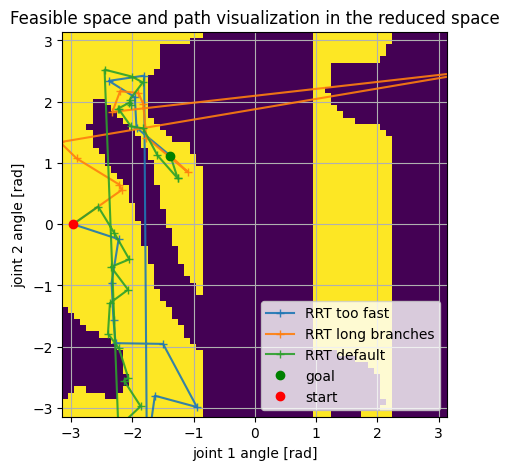

In [131]:
plot_path_in_2d_space(results)

In [132]:
for i in range(len(results)):
    print(results[i][1])
    system.display_motion(results[i][0])

RRT too fast
RRT long branches
RRT default


In [121]:
system.reset()

## Create obstacle with environments

We already had some simple algorithms to find free paths, *i.e.* without obstacles. Let us now add some obstacles to the environment:

And solve RRT. It is long right ? Let us implement more efficient algorithms


![](figures/RRT.png)

## Bi-RRT

Now it's your turn. Make a `BiRRT` class, similar to the `RRT` class above, but implementing the Bi-RRT algorithm. (It is not recommended to try to inherit from `RRT`, as you will end up re-implementing most functions.) Here is a template you are free to adapt, with some advice:

In [133]:
import numpy as np
from system import System
from typing import Callable
from utils.datastructures.storage import Storage
from utils.datastructures.pathtree import PathTree
from utils.datastructures.mtree import MTree
from tqdm import tqdm

FWD = "forward"
BWD = "backward"

class BiRRT():
    def __init__(
        self,
        system: System,
        node_max: int = 500000,
        iter_max: int = 1000000,
        l_min=.2,
        l_max=.5,
        steer_delta=.1,
    ):
        # Initialize attributes:
        self.system = system
        self.l_max = l_max
        self.l_min = l_min
        self.node_max = node_max
        self.iter_max = iter_max
        self.steer_delta = steer_delta

        # New: duplicate this attribute as dictionaries with two keys:
        # "forward" and "backward". See `solve` below.
        self._cached_dist_to_candidate = {}
        self.storage = {}
        self.pathtrees = {}
        self.trees = {}

        self.real_distance = self.system.distance
        self.it_trace = []

    def tree_distance(self, direction: str, q1_idx: int, q2_idx: int) -> float:
        """Compute the real distance
        
        Args:
            q1_idx (int): start node index (in the tree)
            q2_idx (int): end node index (in the tree)

        Returns:
            float: distance
        """
        # Adapt from RRT.distance
        # There is now a direction string to select the underlying tree,
        # either "forward" (from q_init) or "backward" (from q_goal).
        q1, q2 = self.storage[direction][q1_idx], self.storage[direction][q2_idx]
        if q1_idx == q2_idx:
            return 0.
        if q1_idx == -1:
            q1 = self._candidate
        if q2_idx == -1:
            q2 = self._candidate
        dist = self.real_distance(q1, q2)
        return dist

    def forward_distance(self, q1_idx, q2_idx):
        return self.tree_distance(FWD, q1_idx, q2_idx)

    def backward_distance(self, q1_idx, q2_idx):
        return self.tree_distance(BWD, q1_idx, q2_idx)

    def new_candidate(self):
        """Sample a candidate in the free space.
        """
        q = self.system.random_config(free=True)
        self._candidate = q
        for direction in (FWD, BWD):
            self._cached_dist_to_candidate[direction] = {}
        return q
    
    def reset(self):
        # Reset internal datastructures
        for direction in (FWD, BWD):
            self._cached_dist_to_candidate[direction] = {}
            self.storage[direction] = Storage(self.node_max, self.system.nq)
            self.pathtrees[direction] = PathTree(self.storage[direction])
        self.trees = {
            FWD: MTree(self.forward_distance),
            BWD: MTree(self.backward_distance),
        }
        
    def solve(self, qi: np.ndarray, qg: np.ndarray= None) -> bool:
        """Run the BiRRT algorithm
        
        Args:
            qi (np.ndarray): initial configuration
            qg (np.ndarray, optional): goal/target configuration. 
        Return:
            sucess(bool): sucess if a path is found
        """
        assert qg is not None
        # Reset internal datastructures
        self.reset()
        # Root of the forward tree = initial state qi
        qi_idx = self.storage[FWD].add_point(qi)
        self.trees[FWD].add_point(qi_idx)
        # Root of the backward tree = goal state qg
        qg_idx = self.storage[BWD].add_point(qg)
        self.trees[BWD].add_point(qg_idx)
        self.found = False
        iterator = range(self.iter_max)
        for iter in tqdm(iterator):
            if self.found:
                break
            # Standard random sampling
            q_new = self.new_candidate()
            # q_new = np.array([0., 0.]) # FOR TESTING
            q_new_idx = -1
            # Find closest neighboor to q_new in the NNtree
            extension_nodes = {FWD: None, BWD:None}
            for direction in [FWD, BWD]:
                if self.found:
                    break
                q_near_idx, _d_fwd = self.trees[direction].nearest_neighbour(q_new_idx) # q_new_idx = -1
                for delta_ratio in [1., 1/2., 1./4.]:
                    # Progressive refinement of the path collision check.
                    # Allows to quickly discard impossible solutions
                    success, q_prox = self.system.is_free_path(
                        self.storage[direction].data[q_near_idx],
                        q_new,
                        l_min=self.l_min,
                        l_max=self.l_max,
                        eps=self.steer_delta*delta_ratio
                    )
                    if not success:
                        break

                if not success:
                    # print(f"{direction}: FAILED TO CREATE A NEW BRANCH STEERING IN THE q_new direction")
                    self.it_trace.append(0)
                    continue
                self.it_trace.append(1)
                # Add the q_prox point as new node in data structure
                q_prox_idx = self.storage[direction].add_point(q_prox) # add the q_prox point to the storage, get new index
                self.trees[direction].add_point(q_prox_idx) # add the node q_prox to the graph
                self.pathtrees[direction].update_link(q_prox_idx, q_near_idx)
                
                self.system.display_edge(
                    self.storage[direction][q_near_idx],
                    self.storage[direction][q_prox_idx], 
                    color=[1., 1., 1., 1.] if direction == FWD else [1., 0.5, 1., 1.]
                )
                extension_nodes[direction] = q_prox_idx
            DIR_LIST = [FWD, BWD]
            for dir_idx, dir in enumerate(DIR_LIST):
                if self.found:
                    break
                oppo_dir = DIR_LIST[(1-dir_idx)%2]
                assert oppo_dir!=dir
                q_prox_idx = extension_nodes[dir]
                if q_prox_idx is None:
                    continue
                else:
                    newest = self.storage[dir].data[q_prox_idx] # latest candidate
                    self._candidate = newest
                    nearest_idx_oppo, _ = self.trees[oppo_dir].nearest_neighbour(-1) # find nearest neighbor in the opposite tree
                    nearest_oppo = self.storage[oppo_dir].data[nearest_idx_oppo]
                    for delta_ratio in [1., 1/2., 1./4., 1./8.]:
                        success, _ = self.system.is_free_path(
                            newest,
                            nearest_oppo,
                            l_min=None,
                            l_max=None,
                            eps=self.steer_delta*delta_ratio #@TODO: WARNING ON ACCURACY!!!! We can simply loop!
                        )
                        if not success:
                            break
                    if success:
                        print(f"DONE! {dir} Bridge found between {newest} {nearest_oppo}")
                        bridge_index = self.storage[dir].add_point(nearest_oppo) #ADD THE BRIDGE! add the nearest_oppo to the current graph
                        self.pathtrees[dir].update_link(bridge_index, q_prox_idx) #Update the bridge
                        self.found = True # WE HAVE A PATH!
                        self.system.display_edge(newest, nearest_oppo, radius=0.015, color=[0., 0., 1., 1.])
                        break
        return self.found
    def get_path(self):
        assert self.found
        forward_path = self.pathtrees["forward"].get_path()
        backward_path = self.pathtrees["backward"].get_path()
        return np.concatenate([forward_path, backward_path[::-1]])

You should be able to call `BiRRT` similarly to `RRT`:

In [137]:
system.reset()
birrt = BiRRT(
    system,
    l_min=0.2,
    l_max=0.5,
    steer_delta=0.1,
    iter_max=1000
)
success = birrt.solve(q_i, q_g)
final_path = birrt.get_path()


from ipywidgets import interact, IntSlider, FloatSlider
def show_step(step=0):
    current_config = [np.interp(step, xp=np.arange(len(final_path)), fp=final_path[:, dim]) for dim in range(final_path.shape[1])]
    # viz.display(final_path[step])
    current_config = np.array(current_config)
    assert not system.is_colliding(current_config)
    viz.display(current_config)

if success:
    final_path = birrt.get_path()
    system.display_motion(final_path)
    interact(show_step, step=FloatSlider(0, min=0, max=len(final_path)-1));
else:
    print("FAIL")
    print(birrt.get_path())

 20%|██        | 20/100 [00:04<00:18,  4.38it/s]

DONE! forward Bridge found between [-2.92806254  2.22680924] [-2.60073122  2.3212309 ]


interactive(children=(FloatSlider(value=0.0, description='step', max=11.0), Output()), _dom_classes=('widget-i…

In [139]:
system.display_motion(final_path)

RRT too fast
RRT long branches
RRT default


How many iterations did it take to find a solution? Is it faster than previously with `RRT`?

![](figures/birrt_nice.png)
- We can see the tree in white grown from the source(red ball)
- We can see the tree in purple grown from the goal(green ball)
- We can see the bridge between both (found using the nearest neighbor).

In my version, to try to "bridge" the 2 grapsh, I simply used the current candidate:
- found a **single** nearest neighbor in both source and target trees

> note: I'm aware that other strategies could have been employed to bridge the 2 trees, i like the simplicity of the one I implemented though:
> - we could have tried several combinations of the k-nearest neighbors in both trees. If we take k=4, we'd have to test 16 combinations... this could take some time, better keep this time to grow the tree proggressively (not a quantitative benchmark here!)
> - Try random "shortcuts"... we may get lucky... randomly sample a point in the source graph, find its nearest neighbor in the target graph and check connections.

# RRT vs BiRRT

![](figures/bi_rrt_vs_rrt.png)

In the simplified `reduced` case, we can see that the path is more "elegant"... nothing grants that biRRT gets shorter path but in practice it seems to converge to better solutions.
In the biRRT case, I played safe on the collision detection everytime I casted a new path. Even if the "bridge" sometimes looks like having a long length, the path has been verified. When you use the **float slider from iPywidget** , you can see the trajectory interpolated between the nodes of the path and there's an assert in case of collision.


**On the reduced example**

-> RRT ~ 10s ("fast config") -40s (default configuration)
-> biRRT ~ 4seconds

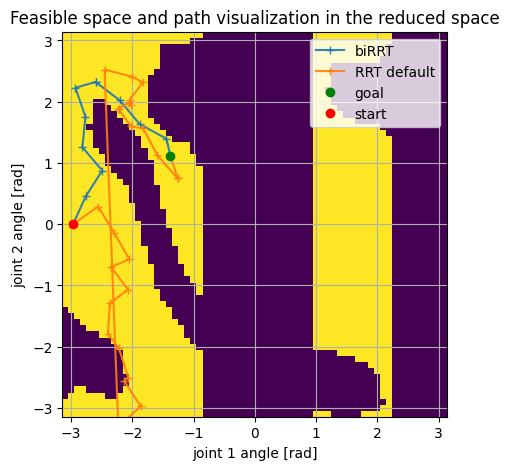

In [141]:
plot_path_in_2d_space([(final_path, "biRRT")]+results[-1:])

## Bonus question: Bi-RRT*

Implement an optimal variant `BiRRTStar` of your `BiRRT` class and run it in the same configuration as the two algorithms above. What do you notice about the resulting tree? What is the improvement in overall path length between `RRT`, `BiRRT` and `BiRRTStar`?